# Language-Visual Saliency with CLIP and OpenVINO™

The notebook will cover:
* What is a _saliency map_ and how it can be used
* What is CLIP neural network and how it can be used to create a saliency maps
* How to split a neural network into parts to infer it separatly
* How to speed up inference with OpenVINO™ and asynchronous execution

## Saliency Maps

Saliency map - is a visualization technique that highlights regions of interest on a picture. It might be used, for example, to [explain an image classificator predictions](https://academic.oup.com/mnras/article/511/4/5032/6529251#389668570) with respect to a particular label. Here is a saliency map for a galaxy image classifier:

![](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/511/4/10.1093_mnras_stac368/3/m_stac368fig1.jpeg?Expires=1677785927&Signature=cAyId2u3u4OTNjPbJbK2DsxUfOUjVavSXbhWy1uZT96E-~gBI8ccSUWpelXZ47XRpw8Ce7jPF1obNUU4jcQtpsINSQimXHu7FUj~fFUBOqt8yeXYupzgVDPys6LfEU-j8u2X1oejwIco~t~PrC65ac3cs40LbUyQVdXZK5RD-I5Hq2~KbTsKRC4pDDzcq5kMWqvTuZ0ux9Qb4FiltdForE4LQbD6CWKl53SmMZ8HHfNrwQDMgXKLEDRfwCYx9qL15jxlxKYGusMuDfdjNbkNf~ex7DKmAsV5JphlDAu6SgBC0SSZ9REZlMXCDqlSKET4RX6fhNWFfbHF3iW3vlYLYQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

*[image source](https://academic.oup.com/mnras/article/511/4/5032/6529251#389668570)

## CLIP

CLIP (Contrastive Language–Image Pre-training) - is a neural network that can work with image and text. It was traind to predict which randomly sampled text snippets is close to the given image, meaning that a text is better describes the image. Here is a visualisation of the pretraining:

![](https://openaiassets.blob.core.windows.net/$web/clip/draft/20210104b/overview-a.svg)
[image_source](https://openai.com/blog/clip/)

To solve the task CLIP uses two parts - `Image Encoder` and `Text Encoder`. Both parts are needed to produce embeddings - vectors of floationg point numbers - from 

In [65]:
import numpy as np
import requests
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch
import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [66]:
model_checkpoin = "openai/clip-vit-base-patch16"
# model_checkpoin = "openai/clip-vit-large-patch14"

model = CLIPModel.from_pretrained(model_checkpoin).eval()
processor = CLIPProcessor.from_pretrained(model_checkpoin)

In [67]:
def get_random_crop_params(image_height, image_width, min_crop_size):
    crop_height = np.random.randint(min_crop_size, image_height)
    crop_width = np.random.randint(min_crop_size, image_width)
    
    x = np.random.randint(image_height - crop_height + 1)
    y = np.random.randint(image_width - crop_width + 1)
    return x, y, crop_height, crop_width


def get_croped_image(im_tensor, x, y, ch, cw):
    return im_tensor[
        ...,
        x : x + ch,
        y : y + cw,
    ]

Ну
def update_saliency_map(saliency_map, similarity, x, y, image):
    saliency_map[
        x : x + image.shape[1],
        y : y + image.shape[2],
    ] += similarity  / (image.shape[1] * image.shape[2])
    

def cosine_similarity(one, other):
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))

In [68]:
n_iters = 2000
window = 100

text = "cat"
picture_url = "https://week.ba/wp-content/uploads/2019/12/porodica-djeca.jpg"
image = Image.open(requests.get(picture_url, stream=True).raw)
x_dim, y_dim = image.size

inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True)
with torch.no_grad():
    results = model(**inputs)

init_cos = cosine_similarity(results.text_embeds, results.image_embeds).item()
saliency_map = np.zeros((x_dim, y_dim))

  0%|          | 0/2000 [00:00<?, ?it/s]

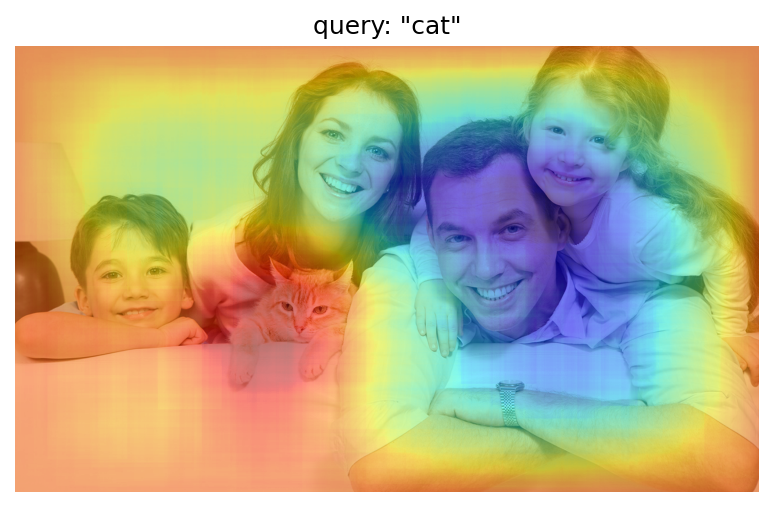

In [69]:
im_tensor = np.array(image).T

for _ in tqdm.notebook.tqdm(range(n_iters)):    
    x, y, ch, cw = get_random_crop_params(x_dim, y_dim, window)
    im_crop = get_croped_image(im_tensor, x, y, ch, cw)

    inputs = processor(text=[text], images=[im_crop], return_tensors="pt", padding=True)
    with torch.no_grad():
        results = model(**inputs)
        text_embeds = results.text_embeds
        image_embeds = results.image_embeds
    
    cosine_sim = cosine_similarity(text_embeds, image_embeds).item() - init_cos
    
    update_saliency_map(saliency_map, cosine_sim, x, y, im_crop)

im_tensor = np.array(image)
plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(saliency_map.T, cmap='jet', alpha=0.5)
plt.title(f'query: \"{text}\"')
plt.axis("off")
plt.show()

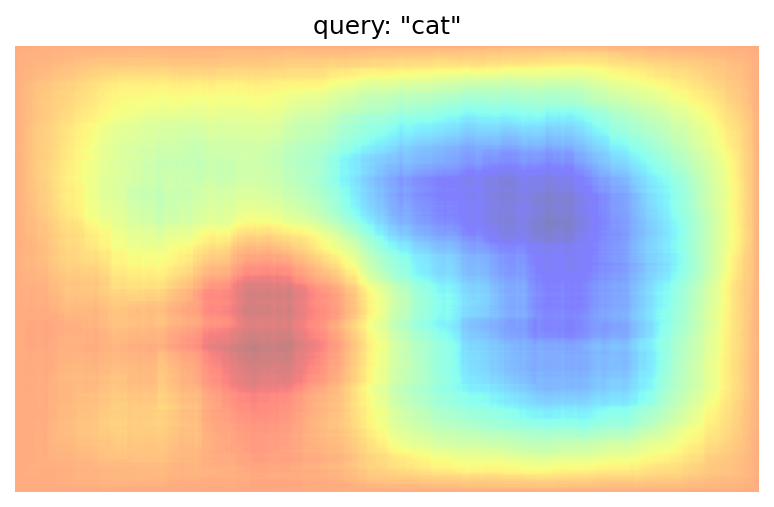

In [71]:
plt.figure(dpi=150)
plt.imshow(saliency_map.T, cmap='jet', alpha=0.5)
plt.title(f'query: \"{text}\"')
plt.axis("off")
plt.show()

## Separate text and visual processing

Take the text processing out of the main loop.

In [7]:
n_iters = 2000
window = 100

text = "cat"
picture_url = "https://week.ba/wp-content/uploads/2019/12/porodica-djeca.jpg"
image = Image.open(requests.get(picture_url, stream=True).raw)
x_dim, y_dim = image.size

inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True)
with torch.no_grad():
    results = model(**inputs)
text_embeds = results.text_embeds

init_cos = cosine_similarity(results.text_embeds, results.image_embeds).item()
saliency_map = np.zeros((x_dim, y_dim))

  0%|          | 0/2000 [00:00<?, ?it/s]

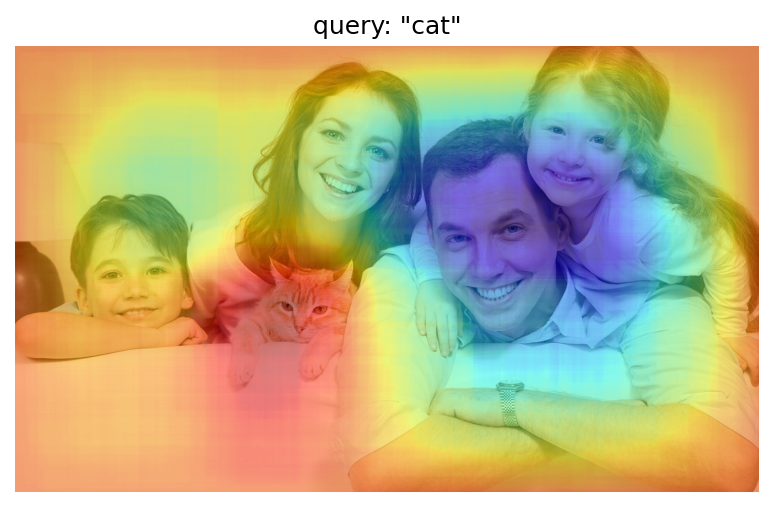

In [8]:
im_tensor = np.array(image).T

for _ in tqdm.notebook.tqdm(range(n_iters)):    
    x, y, ch, cw = get_random_crop_params(x_dim, y_dim, window)
    im_crop = get_croped_image(im_tensor, x, y, ch, cw)

    image_inputs = processor(images=[im_crop], return_tensors="pt", padding=True)
    with torch.no_grad():
        image_embeds = model.get_image_features(**image_inputs)
    
    cosine_sim = cosine_similarity(text_embeds, image_embeds).item() - init_cos
    update_saliency_map(saliency_map, cosine_sim, x, y, im_crop)

im_tensor = np.array(image)
plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(saliency_map.T, cmap='jet', alpha=0.5)
plt.title(f'query: \"{text}\"')
plt.axis("off")
plt.show()

## Convert to OpenVINO

In [9]:
model_name = model_checkpoin.split('/')[-1]

onnx_model_path = Path("onnx") / f"{model_name}.onnx"
onnx_model_path.parent.mkdir(exist_ok=True)

In [10]:
torch.onnx.export(
    model,  # model being run
    # model input in one of acceptable format: torch.Tensor (for single input), tuple or list of tensors for multiple inputs or dictionary with string keys and tensors as values.
    dict(inputs),
    onnx_model_path,  # where to save the model
    opset_version=14,  # the ONNX version to export the model to
    input_names=["input_ids", "pixel_values", "attention_mask"],  # the model's input names
    output_names=["logits_per_image", "logits_per_text", "text_embeds", "image_embeds"],  # the model's output names
    dynamic_axes={  # variable length axes
        "input_ids": {0: "batch", 1: "sequence"},
        "pixel_values": {0: "batch", 1: "num_channels", 2: "height", 3: "width"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits_per_image": {0: "batch"},
        "logits_per_text": {0: "batch"},
        "text_embeds": {0: "batch"},
        "image_embeds": {0: "batch"}
    }
)

/home/apaniuko/python/openvino_notebooks/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/apaniuko/python/openvino_notebooks/venv/lib/python3.10/site-packages/transformers/models/clip/modeling_clip.py:324: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
/home/apaniuko/python/openvino_notebooks/venv/lib/python3.10/site-packages/transf

In [36]:
from openvino.runtime import serialize
from openvino.tools import mo


text_ov_model = mo.convert_model(
    onnx_model_path, 
    compress_to_fp16=True,
    input="input_ids,attention_mask",
    output="text_embeds",
)

input_h_w = ",".join(map(str, processor.image_processor.crop_size.values()))
image_ov_model = mo.convert_model(
    onnx_model_path, 
    compress_to_fp16=True,
    input=f"pixel_values",
    input_shape=f"[1,3,{input_h_w}]",
    output="image_embeds",
)

ov_dir = Path("ir")
ov_dir.mkdir(exist_ok=True)
text_model_path = ov_dir / f"{model_name}_text.xml"
image_model_path = ov_dir / f"{model_name}_image.xml"

serialize(text_ov_model, str(text_model_path))
serialize(image_ov_model, str(image_model_path))

## Inference with OV

In [37]:
from openvino.runtime import Core


core = Core()

text_model = core.read_model(text_model_path)
image_model = core.read_model(image_model_path)

text_model = core.compile_model(model=text_model, device_name="CPU")
image_model = core.compile_model(model=image_model, device_name="CPU")

In [38]:
n_iters = 2000
window = 100

text = "cat"
picture_url = "https://week.ba/wp-content/uploads/2019/12/porodica-djeca.jpg"
image = Image.open(requests.get(picture_url, stream=True).raw)
x_dim, y_dim = image.size

text_inputs = dict(
    processor(text=[text], images=[image], return_tensors="np", padding=True)
)
image_inputs = text_inputs.pop("pixel_values")

text_embeds = text_model(text_inputs)[text_model.output()]
image_embeds = image_model(image_inputs)[image_model.output()]

init_cos = cosine_similarity(text_embeds, image_embeds)
saliency_map = np.zeros((x_dim, y_dim))

  0%|          | 0/2000 [00:00<?, ?it/s]

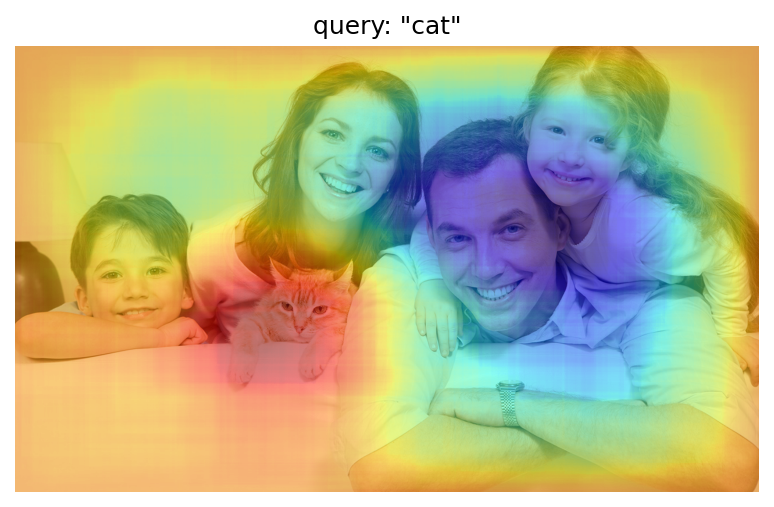

In [39]:
im_tensor = np.array(image).T

for _ in tqdm.notebook.tqdm(range(n_iters)):    
    x, y, ch, cw = get_random_crop_params(x_dim, y_dim, window)
    im_crop = get_croped_image(im_tensor, x, y, ch, cw)

    image_inputs = processor(images=[im_crop], return_tensors="np", padding=True)
    image_embeds = image_model(image_inputs.pixel_values)[image_model.output()]
    
    cosine_sim = cosine_similarity(text_embeds, image_embeds) - init_cos
    update_saliency_map(saliency_map, cosine_sim, x, y, im_crop)

im_tensor = np.array(image)
plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(saliency_map.T, cmap='jet', alpha=0.5)
plt.title(f'query: \"{text}\"')
plt.axis("off")
plt.show()

## Async inference

In [40]:
from openvino.runtime import AsyncInferQueue, InferRequest
from time import time


def completion_callback(
    infer_request: InferRequest, 
    user_data,
) -> None:
    pbar = user_data.pop("pbar")
    image_embeds = next(iter(infer_request.results.values()))
    cosine_sim = (
        cosine_similarity(user_data.pop("text_embeds"), image_embeds) - user_data.pop("init_cos")
    )
    update_saliency_map(**user_data, similarity=cosine_sim)
    pbar.update(1)

In [41]:
n_iters = 2000
window = 100

text = "cat"
picture_url = "https://week.ba/wp-content/uploads/2019/12/porodica-djeca.jpg"
image = Image.open(requests.get(picture_url, stream=True).raw)
x_dim, y_dim = image.size

text_inputs = dict(
    processor(text=[text], images=[image], return_tensors="np", padding=True)
)
image_inputs = text_inputs.pop("pixel_values")

text_embeds = text_model(text_inputs)[text_model.output()]
image_embeds = image_model(image_inputs)[image_model.output()]

init_cos = cosine_similarity(text_embeds, image_embeds)
saliency_map = np.zeros((x_dim, y_dim))

In [42]:
infer_queue = AsyncInferQueue(image_model)
infer_queue.set_callback(completion_callback)

  0%|          | 0/2000 [00:00<?, ?it/s]

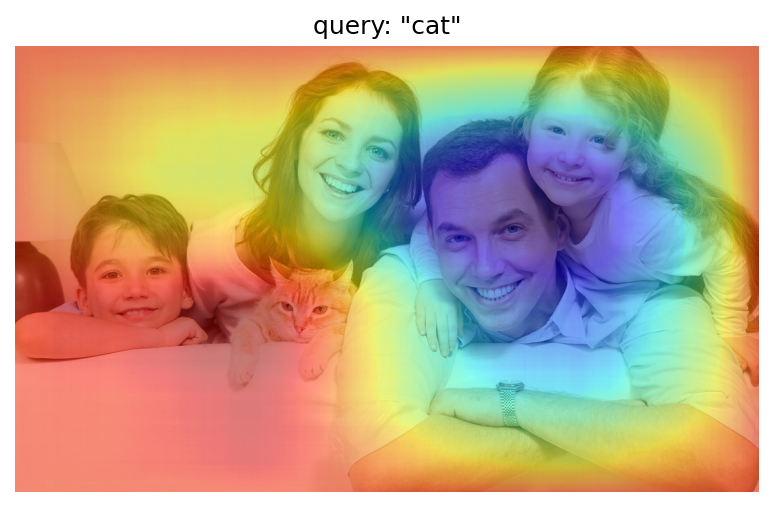

In [59]:
im_tensor = np.array(image).T

with tqdm.notebook.tqdm(total=n_iters) as pbar:
    for _ in range(n_iters):    
        x, y, ch, cw = get_random_crop_params(x_dim, y_dim, window)
        im_crop = get_croped_image(im_tensor, x, y, ch, cw)

        image_inputs = processor(images=[im_crop], return_tensors="np", padding=True)
        infer_queue.start_async(
            image_inputs.pixel_values,
            {
                "text_embeds": text_embeds, 
                "saliency_map": saliency_map,
                "init_cos": init_cos,
                "x": x, 
                "y": y, 
                "image": im_crop,
                "pbar": pbar,
            }
        )

    infer_queue.wait_all()

im_tensor = np.array(image)
plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(saliency_map.T, cmap='jet', alpha=0.5)
plt.title(f'query: \"{text}\"')
plt.axis("off")
plt.show()

## Pack the Pipeline into a Function

In [63]:
import ipywidgets as widgets


def build_saliency_map(image: Image, query: str, n_iter: int = 2000, window=100):
    x_dim, y_dim = image.size
    
    text_inputs = dict(
        processor(text=[query], images=[image], return_tensors="np", padding=True)
    )
    image_inputs = text_inputs.pop("pixel_values")
    
    text_embeds = text_model(text_inputs)[text_model.output()]
    image_embeds = image_model(image_inputs)[image_model.output()]
    
    init_cos = cosine_similarity(text_embeds, image_embeds)
    saliency_map = np.zeros((x_dim, y_dim))
    
    im_tensor = np.array(image).T

    with tqdm.notebook.tqdm(total=n_iters) as pbar:
        for _ in range(n_iters):    
            x, y, ch, cw = get_random_crop_params(x_dim, y_dim, window)
            im_crop = get_croped_image(im_tensor, x, y, ch, cw)

            image_inputs = processor(images=[im_crop], return_tensors="np", padding=True)
            infer_queue.start_async(
                image_inputs.pixel_values,
                {
                    "text_embeds": text_embeds, 
                    "saliency_map": saliency_map,
                    "init_cos": init_cos,
                    "x": x, 
                    "y": y, 
                    "image": im_crop,
                    "pbar": pbar,
                }
            )

        infer_queue.wait_all()

    im_tensor = np.array(image)
    plt.figure(dpi=150)
    plt.imshow(im_tensor)
    plt.imshow(saliency_map.T, cmap='jet', alpha=0.5)
    plt.title(f'Query: \"{query}\"')
    plt.axis("off")
    plt.show()


@widgets.interact_manual(image_link="", query="Cat", n_iter=2000, window=100)
def build_saliency_map_from_image_link(
    image_link: str,
    query: str = "Cat",
    n_iter: int = 2000,
    window: int = 100,
) -> None:
    try:
        image_bytes = requests.get(image_link, stream=True).raw
    except requests.RequestException as e:
        print(f"Cannot load image from link: {image_link}\nException: {e}")
        return
    
    image = Image.open(image_bytes)
    build_saliency_map(image, query, n_iter, window)

/tmp/ipykernel_1384414/2208819839.py:51: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  def build_saliency_map_from_image_link(


interactive(children=(Text(value='', description='image_link'), Text(value='Cat', description='query'), IntSli…

In [64]:
import io


load_file_widget = widgets.FileUpload(multiple=False)

@widgets.interact_manual(file=load_file_widget, query="Cat", n_iter=2000, window=100)
def build_saliency_map_from_file(
    file: Path,
    query: str = "Cat",
    n_iter: int = 2000,
    window: int = 100,
) -> None:
    image_bytes = io.BytesIO(file[0]["content"])
    try:
        image = Image.open(image_bytes)
    except Exception as e:
        print(f"Cannot load the image: {e}")
        return
    
    build_saliency_map(image, query, n_iter, window)

/tmp/ipykernel_1384414/1982046365.py:7: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  def build_saliency_map_from_file(


interactive(children=(FileUpload(value=(), description='Upload'), Text(value='Cat', description='query'), IntS…